In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt

In [289]:
def standardize(data: pd.Series):
    mean = data.mean()
    std = data.std()

    return data.apply(lambda x: (x - mean) / std)


In [290]:
data = pd.read_csv("Dummy-Data-HSS.csv")
data.drop(columns=["Influencer"], inplace=True)
data.fillna(0, inplace=True)

for label in data.columns[:-1]:
    data[label] = standardize(data[label])

data.head(10)

,TV,Radio,Social Media,Sales
0,-1.447401,-1.195158,-0.185872,54.732757
1,-1.561825,-0.919390,-0.410942,46.677897
2,-0.493874,-0.233083,-0.183421,150.177829
3,1.108052,1.225849,1.626880,298.246340
4,-1.485542,-1.002007,-0.864125,56.594181
5,-0.951567,-0.880514,-1.035196,105.889148
6,0.040102,0.696698,0.430803,198.679825
7,-0.875285,-0.081488,-0.465001,108.733932
8,0.841065,0.671417,1.720722,270.189400
9,-1.561825,-1.828452,-0.492290,48.280582


In [388]:
class DataLoader():
    def __init__(self, data: pd.DataFrame, split=0.8):
        self.data_size = len(data)

        self.train_size = int(self.data_size * split)
        self.val_size = self.data_size - self.train_size

        train_data = data[:self.train_size]
        val_data = data[self.train_size:]

        self.input_train = np.array(train_data.drop(data.columns[-1], axis=1))
        self.target_train = np.array(train_data[data.columns[-1]])
        
        self.input_val = np.array(val_data.drop(data.columns[-1], axis=1))
        self.target_val = np.array(val_data[data.columns[-1]])

    def get_inputs(self):
        return self.input_train, self.input_val
    
    def get_targets(self):
        return self.target_train, self.target_val

In [389]:
class LinearRegression():
    def __init__(self):

        self.w = np.zeros(len(data.columns[:-1]))
        self.b = 0

        self._model = lambda x: self.w.dot(x) + self.b

    def train(self, data_loader: DataLoader, epoch = 10, learning_rate = 0.01, lasso = 0, ridge = 0):

        input_train, input_val = data_loader.get_inputs() 
        target_train, target_val = data_loader.get_targets()

        train_size = data_loader.train_size
        val_size = data_loader.val_size

        train_costs = []
        val_costs = []

        sign = np.vectorize(lambda x : 1 if x >= 0 else -1)

        for _ in range(epoch):
            train_cost = 0
            val_cost = 0

            for idx in range(train_size):
                input, target = input_train[idx], target_train[idx]

                prediction = self._model(input)

                error = (prediction - target)

                train_loss = np.power(error, 2) / 2

                train_cost += train_loss

                l1_update = lasso * sign(self.w)

                l2_update = (2 * ridge) * self.w

                regularization_term = l1_update + l2_update

                update_term = (error * input) + regularization_term

                self.w -= learning_rate * update_term

                self.b -= learning_rate * error


            for idx in range(val_size):
                input, target = input_val[idx], target_val[idx]

                prediction = self._model(input)

                error = (prediction - target)

                val_loss = np.power(error, 2) / 2

                val_cost += val_loss


            train_costs.append(train_cost / train_size)
            val_costs.append(val_cost / val_size)

        return train_costs, val_costs

In [390]:
data_loader = DataLoader(data)

model = LinearRegression()

train_cost, val_cost = model.train(data_loader, 10, 0.0001)

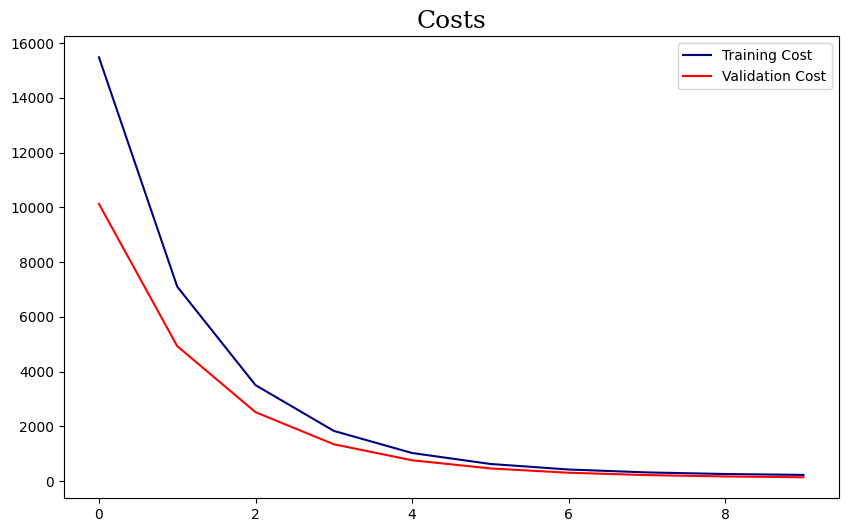

In [391]:
plt.figure(figsize=(10, 6))

plt.plot(train_cost, color="navy", label="Training Cost")
plt.plot(val_cost, color="red", label="Validation Cost")

plt.title("Costs", size=18, family="serif")
plt.legend(loc="upper right")

plt.show()